In [4]:
import taichi as ti
ti.init(arch=ti.vulkan)  # Alternatively, ti.init(arch=ti.cpu)


# Net properties
# net is 5m x 3m, e.g. a proportion of 5x3 for the net nodes
width = 107
height = 64

quad_size_width = 5.0 / width
quad_size_height = 3.0 / height

spring_Y = 1e5 #1e5
yield_force = 5e5 # 1.1e5
dashpot_damping = 1e4 #1e4
drag_damping = 5
node_mass = ti.field(dtype=float, shape=(width, height))
node_mass.fill(0.5) # node mass kg

# Ball properties
ball_radius = 0.5
ball_mass = ti.field(dtype=float, shape=())
ball_mass[None] = 3000.0  # kg. Reinforced concrete ball with a radius of 10 cm, density of 2400 kg/m^3.
ball_center = ti.Vector.field(3, dtype=float, shape=(1, ))
ball_velocity = ti.Vector.field(3, float, (1,))

# Rope properties
rope_length = 20  # five times longer than the net
rope_elements = rope_length * 10
upper_bearing_rope_x = ti.Vector.field(3, float, shape = rope_elements)
upper_bearing_rope_v = ti.Vector.field(3, float, shape = rope_elements)
lower_bearing_rope_x = ti.Vector.field(3, float, shape = rope_elements)
lower_bearing_rope_v = ti.Vector.field(3, float, shape = rope_elements)

# Collision properties
k = 1e6  # proportionality constant for collision response force
damping_ratio = 150  # 0.1 damping ratio for collision

# Simulation parameters
dt = 1e-2 / max(width, height) #8e-3
substeps = int(1 / 60 // dt) #1/120
gravity = ti.Vector([0, -9.8, 0])


x = ti.Vector.field(3, dtype=float, shape=(width, height)) # matrix of size 107x64 where each entry is a 3-dimensional vector
v = ti.Vector.field(3, dtype=float, shape=(width, height))

shackle_position = ti.Vector.field(3, dtype=ti.f32, shape=(width, 2))
shackle_velocity = ti.Vector.field(3, dtype=ti.f32, shape=(width, 2))

num_triangles = (width - 1) * (height - 1) * 2
indices = ti.field(int, shape=num_triangles * 3)
vertices = ti.Vector.field(3, dtype=float, shape=width * height)
colors = ti.Vector.field(3, dtype=float, shape=width * height)

bending_springs = False # bending springs facilitate bending or deformation by introducing additional connections between particles

@ti.kernel
def init_rope_positions_and_velocities():
    for i in range(upper_bearing_rope_x.shape[0]):
        upper_bearing_rope_x[i] = ti.Vector([i * 0.1 - 7.5, 0.0, 0.0])
        upper_bearing_rope_v[i] = ti.Vector([0, 0, 0])

    for i in range(lower_bearing_rope_x.shape[0]):
        lower_bearing_rope_x[i] = ti.Vector([i * 0.1 - 7.5, 0.0, 3])
        lower_bearing_rope_v[i] = ti.Vector([0, 0, 0])

init_rope_positions_and_velocities()

@ti.kernel
def initialize_points():
    for i, j in x:
        x[i, j] = [
            i * quad_size_width , 0, j * quad_size_height
        ]
        v[i, j] = [0, 0, 0]

        # Initialize shackles only at the top and bottom boundaries of the net
        if j == 0 or j == height-1:
            shackle_position[i, j // (height - 1)] = x[i, j]
            shackle_velocity[i, j // (height - 1)] = [0, 0, 0]

    ball_center[0] = ti.Vector([2.5, 15, 1.5]) #ti.Vector([0.5, 1, 0.25]) # 0.5, 1, 0.25 for a shifted impact. Ball starts from a height
    ball_velocity[0] = ti.Vector([0.0, 0.0, 0.0]) # Ball's initial velocity

@ti.kernel
def initialize_mesh_indices(): # since Taichi only supports the rendering of triangles, we have to build squares by putting 2 triangles together
    for i, j in ti.ndrange(width - 1, height - 1):
        quad_id = (i * (height - 1)) + j
        # 1st triangle of the square
        indices[quad_id * 6 + 0] = i * height + j
        indices[quad_id * 6 + 1] = (i + 1) * height + j
        indices[quad_id * 6 + 2] = i * height + (j + 1)
        # 2nd triangle of the square
        indices[quad_id * 6 + 3] = (i + 1) * height + j + 1
        indices[quad_id * 6 + 4] = i * height + (j + 1)
        indices[quad_id * 6 + 5] = (i + 1) * height + j

    for i, j in ti.ndrange(width, height):
        if (i // 4 + j // 4) % 2 == 0:
            colors[i * height + j] = (0.8, 0.8, 0.8)
        else:
            colors[i * height + j] = (0.5, 0.5, 0.5)

initialize_mesh_indices()

spring_offsets = []
if bending_springs:
    for i in range(-2, 3):
        for j in range(-2, 3):
            if (i, j) != (0, 0) and abs(i) + abs(j) <= 2:
                spring_offsets.append(ti.Vector([i, j]))
else:
    for i in range(-1, 2):
        for j in range(-1, 2):
            if (i, j) != (0, 0):
                spring_offsets.append(ti.Vector([i, j]))

# Shackles logic
shackle_spring_pj = 1e6
shackle_damp_pj = 1e3

@ti.func
def pin_joint(i, j, pos, vel):
    force1 = ti.Vector([0, 0, 0])  # Initialize force
    dist = (shackle_position[i, j] - pos).norm()
    if dist > 0.01:
        direction = (shackle_position[i, j] - pos).normalized()
        relative_vel = vel - shackle_velocity[i, j]
        spring_force = shackle_spring_pj * (dist - 0.01) * direction
        damper_force = -shackle_damp_pj * relative_vel
        force = spring_force + damper_force

    return force1

shackle_spring_sj = 1e4
shackle_damp_sj = 1e2

@ti.func
def sliding_joint(i, j, rope_x, rope_v, pos, vel):
    direction = (rope_x[i + 1] - rope_x[i]).normalized()
    relative_pos = pos - rope_x[i]
    relative_vel = vel - rope_v[i]

    projected_pos = relative_pos.dot(direction) * direction
    projected_vel = relative_vel.dot(direction) * direction

    lateral_pos = relative_pos - projected_pos
    lateral_vel = relative_vel - projected_vel

    spring_force = -shackle_spring_sj * lateral_pos
    damper_force = -shackle_damp_sj * lateral_vel

    force2 = spring_force + damper_force

    return force2

shackle_pos_field_1D = ti.Vector.field(3, dtype=ti.f32, shape=width*2)

@ti.kernel
def substep():
    for i in ti.grouped(x):
        v[i] += gravity * dt

    for i in ti.grouped(x):
        force = ti.Vector([0.0, 0.0, 0.0])
        for spring_offset in ti.static(spring_offsets):
            j = i + spring_offset
            if 0 <= j[0] < width and 0 <= j[1] < height:
                x_ij = x[i] - x[j]
                v_ij = v[i] - v[j]
                d = x_ij.normalized()
                current_dist = x_ij.norm()

                grid_dist_ij = ti.Vector([abs(i[0] - j[0]) * quad_size_width,
                          abs(i[1] - j[1]) * quad_size_height])
                original_dist = grid_dist_ij.norm()

                # # Spring force
                # force += -spring_Y * d * (current_dist / original_dist - 1)

                # Spring force with yielding
                displacement_ratio = current_dist / original_dist - 1
                if displacement_ratio < yield_force / spring_Y:
                    force += -spring_Y * displacement_ratio * d
                else:
                    force += -yield_force * d
                
                # Dashpot damping
                force += -v_ij.dot(d) * d * dashpot_damping * min(quad_size_width, quad_size_height)

        v[i] += force * dt / node_mass[i]
        
    for i in ti.grouped(x):
        v[i] *= ti.exp(-drag_damping * dt)
        displacement = x[i] - ball_center[0]
        distance = displacement.norm()
        if distance <= ball_radius:
            collision_normal = displacement.normalized()
            penetration_depth = ball_radius - distance
            collision_response_force = k * penetration_depth ** 2 * collision_normal  # collision response force
            relative_velocity = v[i] - ball_velocity[0]  # relative velocity of the node and the ball
            damping_force = damping_ratio * relative_velocity.dot(collision_normal) * collision_normal  # damping force

            # Update the node's position and velocity
            x[i] += penetration_depth * collision_normal
            v[i] += (collision_response_force * dt - damping_force * dt) / node_mass[i]  # consider mass when updating velocity

            # Update the ball's velocity
            ball_velocity[0] -= (collision_response_force * dt - damping_force * dt) / ball_mass[None]  # consider mass when updating velocity
        
        # # Conditions for the angle points of the net
        # if i[0] != 0 and i[0] != width-1 and i[1] != 0 and i[1] != height-1:
        #     x[i] += dt * v[i]
        # #x[i] += dt * v[i]
    
    # Add motion for the ball
    ball_velocity[0].y += gravity.y * dt  # Gravity acts on ball
    ball_center[0] += dt * ball_velocity[0]

    for i, j in ti.ndrange(width, 2):
        force1 = pin_joint(i, j, x[i, j * (height - 1)], v[i, j * (height - 1)])
        v[i, j * (height - 1)] += dt * force1 / node_mass[i, j * (height - 1)]

    # Add sliding_joint forces
    for i in range(width):
        for j in range(2):
            force2 = ti.Vector([0.0, 0.0, 0.0])
            if j == 0:
                force2 = sliding_joint(i, j, upper_bearing_rope_x, upper_bearing_rope_v, x[i, j * (height - 1)], v[i, j * (height - 1)])
            else:
                force2 = sliding_joint(i, j, lower_bearing_rope_x, lower_bearing_rope_v, x[i, j * (height - 1)], v[i, j * (height - 1)])
            
            v[i, j * (height - 1)] += dt * force2 / node_mass[i, j * (height - 1)]
            shackle_velocity[i, j] += dt * force2 / node_mass[i, j * (height - 1)]

    # Update position
    for i, j in x:
        x[i, j] += dt * v[i, j]
        if j == 0 or j == height-1:
            shackle_position[i, j // (height - 1)] = upper_bearing_rope_x[i] if j == 0 else lower_bearing_rope_x[i]

    for i in range(width):
        for j in range(2):
            shackle_pos_field_1D[i * 2 + j] = shackle_position[i, j]

    # for i in ti.grouped(x):
    #     x[i] += dt * v[i]

@ti.kernel
def update_vertices():
    for i, j in ti.ndrange(width, height):
        vertices[i * height + j] = x[i, j]

window = ti.ui.Window("Taichi Cloth Simulation on GGUI", (1024, 1024),
                      vsync=True)
canvas = window.get_canvas()
#canvas.set_background_color((1, 1, 1))
scene = ti.ui.Scene()
camera = ti.ui.Camera()

current_t = 0.0
initialize_points()

while window.running:
    if current_t > 7.5:
        # Reset
        initialize_points()
        current_t = 0

    for i in range(substeps):
        substep()
        current_t += dt
    #update_boundary_nodes()
    update_vertices()

    camera.position(10, 10, 20)
    camera.lookat(2.5, 0.0, 0)
    scene.set_camera(camera)

    scene.point_light(pos=(0, 1, 2), color=(1, 1, 1))
    scene.ambient_light((0.5, 0.5, 0.5))
    scene.mesh(vertices,
               indices=indices,
               per_vertex_color=colors,
               two_sided=True)

    # Draw a smaller ball to avoid visual penetration
    scene.particles(ball_center, radius=ball_radius * 0.95, color=(1, 0, 0))
    scene.lines(upper_bearing_rope_x, color=(0.5, 0.5, 0.5), width=2)
    scene.lines(lower_bearing_rope_x, color=(0.5, 0.5, 0.5), width=2)
    #scene.particles(shackle_pos_field_1D, radius=0.05, color=(0, 0, 1))
    canvas.scene(scene)
    window.show()

[Taichi] version 1.6.0, llvm 15.0.1, commit f1c6fbbd, win, python 3.11.3
[Taichi] Starting on arch=vulkan


: 

: 

In [ ]:
    # for i in range(1, upper_bearing_rope_x.shape[0]-1):  # Skip the extremities
    #     # Bottom boundary nodes
    #     node_position = x[i, 0] if i < width else lower_bearing_rope_x[i]
    #     rope_position = lower_bearing_rope_x[i]
    #     direction = ti.Vector([rope_position.x - node_position.x, rope_position.y - node_position.y, rope_position.z - node_position.z]).normalized()
    #     v_projected = v[i, 0].dot(direction) * direction if i < width else ti.Vector([0, 0, 0])
    #     v[i, 0] = v_projected  # Update velocity
    #     x[i, 0] += v_projected * dt  # Update position
    #     lower_bearing_rope_x[i] -= v_projected * dt  # Move the rope

    #     # Top boundary nodes
    #     node_position = x[i, height-1] if i < width else upper_bearing_rope_x[i]
    #     rope_position = upper_bearing_rope_x[i]
    #     direction = ti.Vector([rope_position.x - node_position.x, rope_position.y - node_position.y, rope_position.z - node_position.z]).normalized()
    #     v_projected = v[i, height-1].dot(direction) * direction if i < width else ti.Vector([0, 0, 0])
    #     v[i, height-1] = v_projected  # Update velocity
    #     x[i, height-1] += v_projected * dt  # Update position
    #     upper_bearing_rope_x[i] -= v_projected * dt  # Move the rope

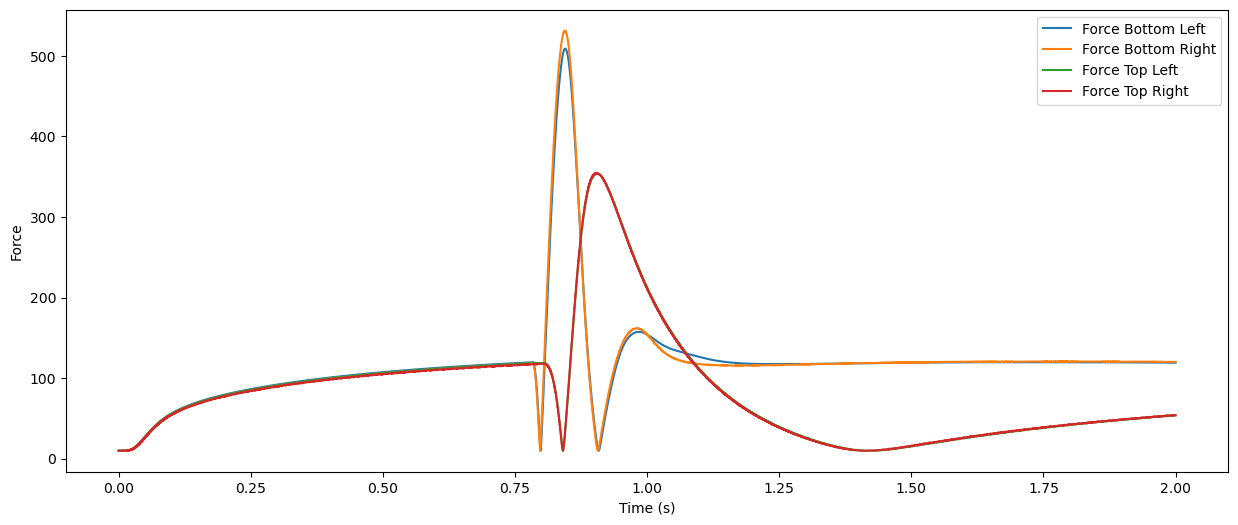

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Plot the forces over time using the updated lists
time = np.arange(steps) * dt
plt.figure(figsize=(15, 6))
plt.plot(time, force_bottom_left_list, label='Force Bottom Left')
plt.plot(time, force_bottom_right_list, label='Force Bottom Right')
plt.plot(time, force_top_left_list, label='Force Top Left')
plt.plot(time, force_top_right_list, label='Force Top Right')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.show()

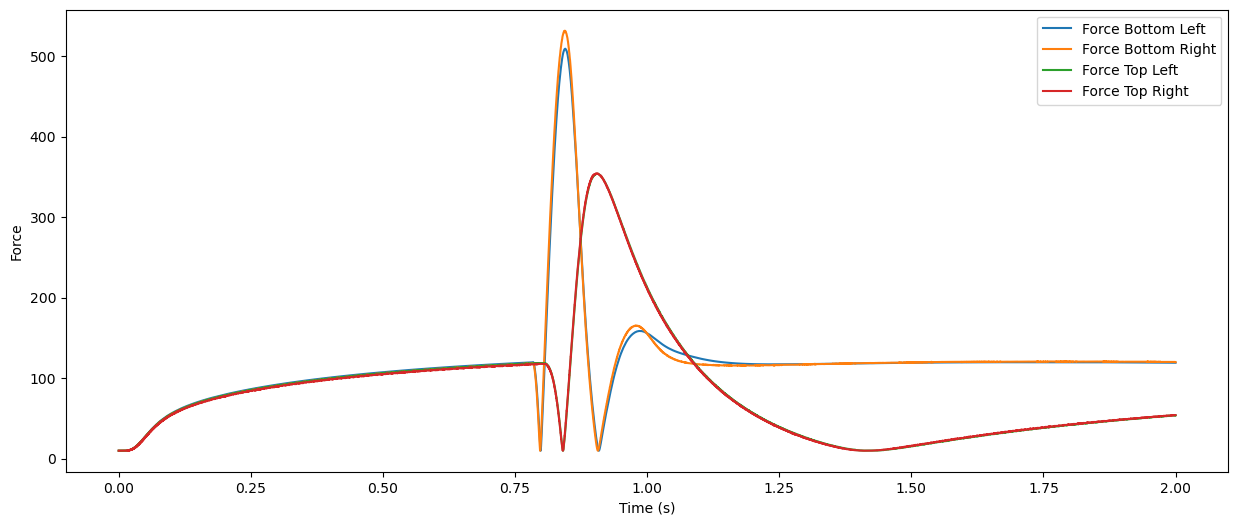

In [4]:
# Plot the forces over time using the updated lists
time = np.arange(steps) * dt
force_bottom_left_filtered = [f for f in force_bottom_left_list if f > 0]
force_bottom_right_filtered = [f for f in force_bottom_right_list if f > 0]
force_top_left_filtered = [f for f in force_top_left_list if f > 0]
force_top_right_filtered = [f for f in force_top_right_list if f > 0]

# Ensure filtered force arrays have the same length as time
num_filtered = min(len(time), len(force_bottom_left_filtered), len(force_bottom_right_filtered), len(force_top_left_filtered), len(force_top_right_filtered))
time = time[:num_filtered]
force_bottom_left_filtered = force_bottom_left_filtered[:num_filtered]
force_bottom_right_filtered = force_bottom_right_filtered[:num_filtered]
force_top_left_filtered = force_top_left_filtered[:num_filtered]
force_top_right_filtered = force_top_right_filtered[:num_filtered]

plt.figure(figsize=(15, 6))
plt.plot(time, force_bottom_left_filtered, label='Force Bottom Left')
plt.plot(time, force_bottom_right_filtered, label='Force Bottom Right')
plt.plot(time, force_top_left_filtered, label='Force Top Left')
plt.plot(time, force_top_right_filtered, label='Force Top Right')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force')
plt.show()

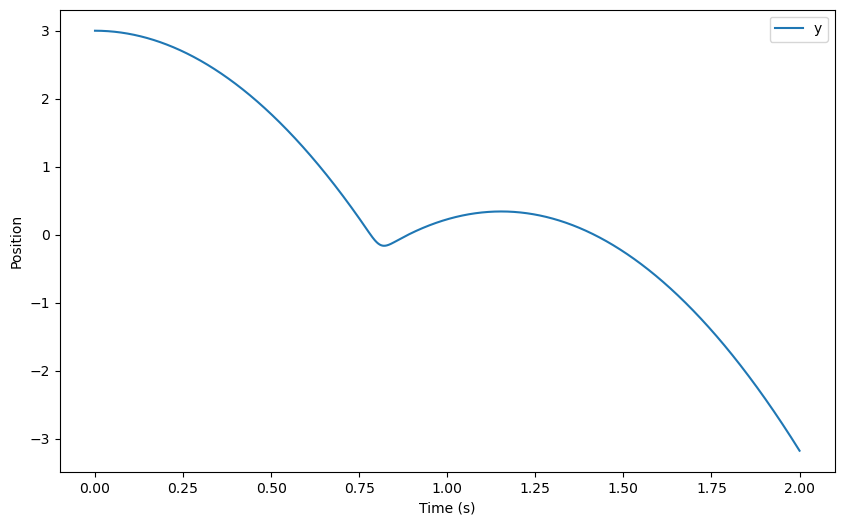

In [3]:
# Convert the ball_positions list to a NumPy array
ball_positions = np.array(ball_positions)

# Adjust the lengths of time and ball position arrays
time = np.arange(steps) * dt
num_positions = min(len(time), ball_positions.shape[0])
time = time[:num_positions]
ball_positions = ball_positions[:num_positions]

# Extract x, y, z positions separately
ball_x = ball_positions[:, 0]
ball_y = ball_positions[:, 1]
ball_z = ball_positions[:, 2]

# Plot the time/position diagram
plt.figure(figsize=(10, 6))
#plt.plot(time, ball_x, label='x')
plt.plot(time, ball_y, label='y')
#plt.plot(time, ball_z, label='z')
plt.xlabel('Time (s)')
plt.ylabel('Position')
plt.legend()
plt.show()

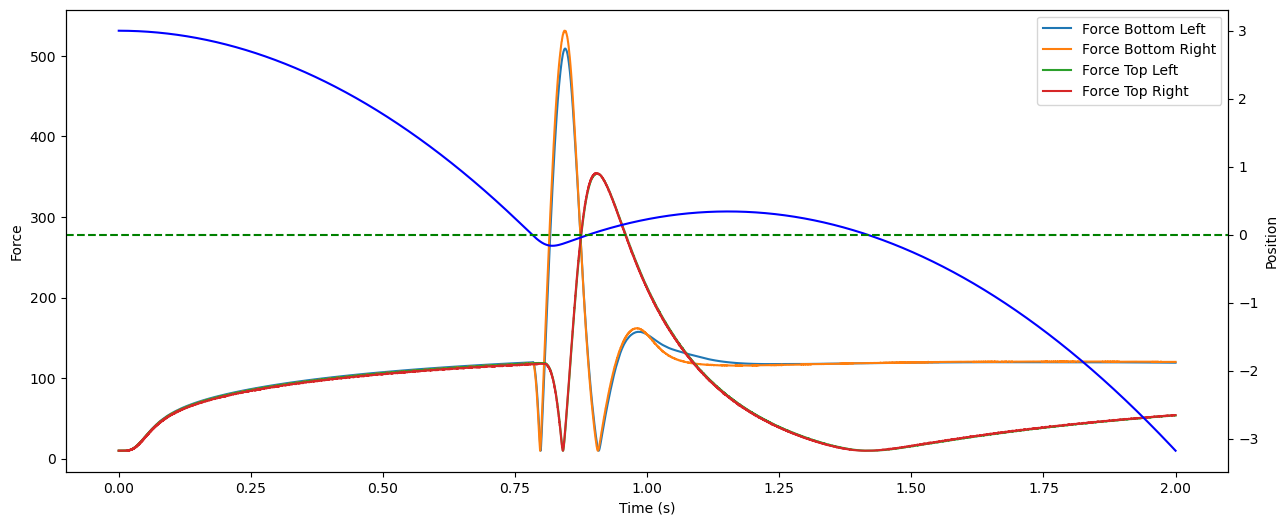

In [4]:
# Plot the forces over time using the updated lists
time = np.arange(steps) * dt
plt.figure(figsize=(15, 6))
plt.plot(time, force_bottom_left_list, label='Force Bottom Left')
plt.plot(time, force_bottom_right_list, label='Force Bottom Right')
plt.plot(time, force_top_left_list, label='Force Top Left')
plt.plot(time, force_top_right_list, label='Force Top Right')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Force')

# Create a second y-axis for ball positions
plt2 = plt.twinx()
plt2.plot(time, ball_y, 'b', label='Ball Position (y)')
plt2.set_ylabel('Position')

# Draw a horizontal line at position = 0
plt.axhline(y=0, color='g', linestyle='--', label='Position = 0')

# Show both plots
plt.show()